In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

from subprocess import check_output

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

FileNotFoundError: [Errno 2] File b'train.csv' does not exist: b'train.csv'

In [3]:
# drop the 'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Data preprocessing

In [4]:
# delete outliers

train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [5]:
# log transform target variable (its right skewed)

train["SalePrice"] = np.log1p(train["SalePrice"])

## Feature engineering

In [6]:
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
y_train = train.SalePrice.values

In [7]:
# missing data

all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [8]:
# changing numerical to categorical (if applicable)

all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [9]:
# categorical: label encoding

from sklearn.preprocessing import LabelEncoder;

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold');

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder(); 
    lbl.fit(list(all_data[c].values)); 
    all_data[c] = lbl.transform(list(all_data[c].values));

# shape        
print('Shape all_data: {}'.format(all_data.shape));

Shape all_data: (2917, 78)


In [10]:
# add new feature (total area)

all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [11]:
# skewness: box-cox transformation (in place of log transformations)

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)


Skew in numerical features: 



Skew
MiscVal       21.940
PoolArea      17.689
LotArea       13.109
LowQualFinSF  12.085
3SsnPorch     11.372
LandSlope      4.973
KitchenAbvGr   4.301
BsmtFinSF2     4.145
EnclosedPorch  4.002
ScreenPorch    3.945

There are 59 skewed numerical features to Box Cox transform


In [12]:
# categorical: dummy variables

all_data = pd.get_dummies(all_data)

In [13]:
# new train and test sets
ntrain = train.shape[0]
ntest = test.shape[0]

train = all_data[:ntrain]
test = all_data[ntrain:]

# Modelling

In [14]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [15]:
# validation function

n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values) # shuffle dataset prior to cv
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [16]:
# get base models (and make robust to outliers)

lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, random_state=3))
KRR = KernelRidge(alpha=0.7, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000,
                                  learning_rate=0.05,
                                  max_depth=4,
                                  max_features='sqrt',
                                  min_samples_leaf=15,
                                  min_samples_split=10,
                                  loss='huber',
                                  random_state=5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603,
                            gamma=0.0468,
                            learning_rate=0.05,
                             max_depth=3, 
                             min_child_weight=1.7817, 
                             n_estimators=2200,
                             reg_alpha=0.4640,
                             reg_lambda=0.8571,
                             subsample=0.5213,
                             silent=1,
                             random_state =7,
                             nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',
                              num_leaves=5,
                              learning_rate=0.05,
                              n_estimators=720,
                              max_bin = 55, 
                              bagging_fraction = 0.8,
                              bagging_freq = 5, 
                              feature_fraction = 0.2319,
                              feature_fraction_seed=9, 
                              bagging_seed=9,
                              min_data_in_leaf =6, 
                              min_sum_hessian_in_leaf = 11)

In [18]:
rmsle_cv(lasso).mean()
rmsle_cv(ENet).mean()
rmsle_cv(GBoost).mean()
rmsle_cv(model_xgb).mean()
rmsle_cv(model_lgb).mean()

0.1115440156513821

0.11246723221874941

0.11767542523862462

0.11678623520127354

0.11510962837217997

## Stacking models

### Averaging base models (simple stacking)

In [21]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    
    
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]    # define copies of original models to fit the data in
        
        for model in self.models_:
            model.fit(X,y)
        
        return self


    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])  # do predictions of cloned models
        return np.mean(predictions, axis=1)                                          # then average them

In [22]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

array([0.10053717, 0.11386236, 0.12125041, 0.10236341, 0.1078164 ])

In [23]:
rmsle_cv(averaged_models).mean()

0.10916594847256114

### Adding a Meta-model

1. Split the total training set into two disjoint sets (here **train** and **.holdout**)
2. Train several base models on the first part (**train**)
3. Test these base models on the second part (**holdout**)
4. Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called **meta-model**.

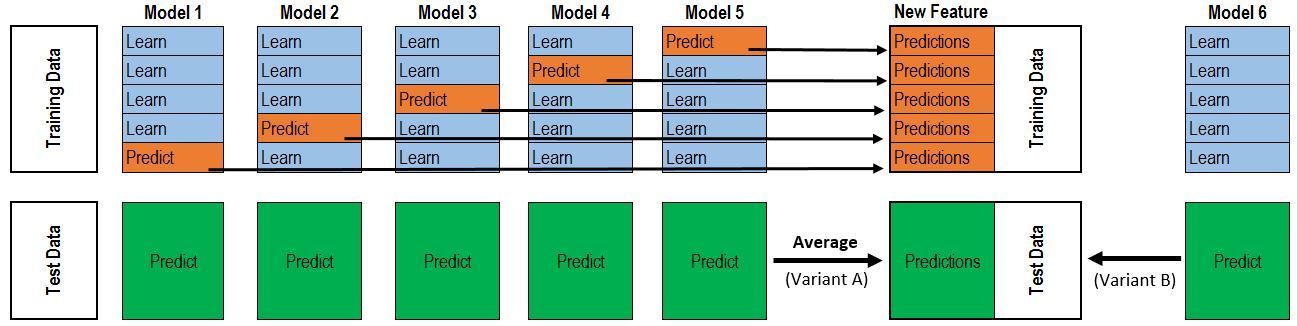

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration, we train every base model on 4 folds and predict on the remaining fold (holdout fold).

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as new feature to train our meta-model in the step 4.

In [24]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
        
        
    def fit(self, X, y):
        # clone models
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])        # train cloned models
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred  # create predictions to be used on meta-model
                
        self.meta_model_.fit(out_of_fold_predictions, y)  # train cloned meta-model
        
        return self
    
    
    
    def predict(self, X):
        meta_features = np.column_stack([  # predictions of all base models with test data, use average for the meta model prediction
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1) 
            for base_models in self.base_models_
        ])
        
        return self.meta_model_.predict(meta_features)

In [26]:
stacked_averaged_models = StackingAveragedModels(base_models=(ENet, GBoost, KRR),
                                               meta_model=lasso)

score = rmsle_cv(stacked_averaged_models)
score.mean(), score.std()

(0.10857416171306342, 0.007641018012252603)

### Ensembling StackedRegressor, XGBoost, LightGBM

In [27]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [28]:
# just stacked regressor

stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
rmsle(y_train, stacked_train_pred)

StackingAveragedModels(base_models=(Pipeline(memory=None,
                                             steps=[('robustscaler',
                                                     RobustScaler(copy=True,
                                                                  quantile_range=(25.0,
                                                                                  75.0),
                                                                  with_centering=True,
                                                                  with_scaling=True)),
                                                    ('elasticnet',
                                                     ElasticNet(alpha=0.0005,
                                                                copy_X=True,
                                                                fit_intercept=True,
                                                                l1_ratio=0.5,
                                                             

0.07623215648917482

In [29]:
# XGboost

model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1.7817, missing=None,
             n_estimators=2200, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, seed=None, silent=1, subsample=0.5213,
             verbosity=1)

0.07900074237023577


In [30]:
# LightGBM

model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.05, max_bin=55,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=6, min_split_gain=0.0,
              min_sum_hessian_in_leaf=11, n_estimators=720, n_jobs=-1,
              num_leaves=5, objective='regression', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

0.07210084277592503


# Scoring

In [31]:
# entire train data when averaging 

print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

0.07402605965278575


In [32]:
# ensemble prediction

ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [44]:
# submission
sub = pd.DataFrame()
sub['SalePrice'] = ensemble
sub['Id'] = sub.index + 1
sub = sub[['Id', 'SalePrice']]
sub.to_csv('house_submission.csv',index=False)

In [43]:
sub.head()

Id  SalePrice
0   1 119735.302
1   2 159758.868
2   3 187215.533
3   4 195247.031
4   5 193119.757